# A/B-тест для интернет магазина

**ВВОДНЫЕ ДАННЫЕ**:
Для крупного интернет-магазина для увеличения выручки отделом маркетинга подготовлен список гипотез. Нам предстоит провести приоритезацию гипотез, запустить A/B-тест и проанализировать результаты.
 

**Цель** -  анализ результатов проведения A/B-теста.

**Задачи**:
 - приоритизация гипотез;
 - запуск A/B-тест;
 - анализ результатов А/В-тестов.
 

План работы:
1. Описание данных
1. Приоритизация гипотез
1. Загрузка данных и подготовка их к анализу
1. Фреймворк ICE для приоритизации гипотез
1. Фреймворк RICE для приоритизации гипотез
1. Изменения приоритизации гипотез при применении RICE вместо ICE. Причины
1. Итоги раздела
1. Анализ А/В теста
1. Предобработка
1. График кумулятивной выручки по группам
1. График кумулятивного среднего чека по группам.
1. График относительного изменения кумулятивного среднего чека группы В к группе А.
1. График кумулятивной конверсии по группам
1. График относительного изменения кумулятивной конверсии группы В к группе А
1. Точечный график количества заказов по пользователям
1. Посчитаем выборочные 95-й и 99-й перцентили количества заказов на одного пользователя
1. Точечный график стоимости заказов
1. Посчитаем выборочные 95-й и 99-й перцентили стоимости заказов
1. Статистическая значимость различия в конверсии между группами по "сырым" данным.
1. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.
1. Статистическая значимость различий в конверсии между группами по «очищенным» данным.
1. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным
1. Вывод


## Описание данных
### Данные для первой части
**Путь к файлу** 
    - Файл /datasets/hypothesis.csv [Скачать датасет](https://вырезано.csv) 
    
**Описание** - ГИПОТЕЗЫ
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.



### Данные для второй части
**Путь к файлу** 
    - Файл /datasets/orders.csv [Скачать датасет](https://вырезано.csv)
       
**Описание** ЗАКАЗЫ
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ. 
 
**Путь к файлу** 
    - Файл /datasets/visitors.csv [Скачать датасет](https://вырезано.csv)
    
**Описание** ПОЛЬЗОВАТЕЛИ
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Библиотеки для работы

In [1]:
import pandas as pd #
pd.set_option('max_colwidth', 150) # увеличение ширины столбца

import numpy as np #

import datetime as dt

from datetime import datetime, timedelta 

import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline

import plotly.express as px
from plotly.offline import iplot

import seaborn as sns

import scipy.stats as stats
from scipy import stats
from scipy import spatial

## Приоритизация гипотез

### Загрузка данных и подготовка их к анализу

In [2]:
# гипотезы
try:
    hypothesis = pd.read_csv('https://вырезано', sep=',')
     
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
hypothesis    

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
hypothesis.columns = hypothesis.columns.str.lower()
print(' Преобразовали наименование столбцов датафрейма hypothesis в нижний регистр:\n', list(hypothesis))

 Преобразовали наименование столбцов датафрейма hypothesis в нижний регистр:
 ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']


### Фреймворк ICE для приоритизации гипотез

C помощью фреймворка ICE проведем приоритезацию гипотез из датафрейма hypothesis. 

Формула: **impact * confidence / efforts**,  умножаем влияние на пользователей impact на уверенность в гипотезе confidence и делим на затраты ресурсов на проверку гипотезы efforts. Округлим значение до двух знаков после запятой.

In [4]:
hypothesis['ice'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
print(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)) 

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

Выделяется три наиболее перспективные гипотезы по ICE: 
8, 0, 7, 
 - № 8 "Запустить акцию, дающую скидку на товар в день рождения"   
 - № 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  " 
 - № 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" 

еще две гипотезы № 6 и № 2 набрали меньше баллов чем лидеры, но сильно больше чем аутсайдеры:
 - № 6 "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
 - № 2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
 
аутсайдеры - гипотезы набравшие наименьшее число баллов под номерами: 1, 5, 3, 4:
 - № 1 "Запустить собственную службу доставки, что сократит срок доставки заказов"
 - № 5 "Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
 - № 3 "Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
 - № 4 "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


### Фреймворк RICE для приоритизации гипотез

Теперь посмотрим как будет расставлен приоритет гипотез из датафрейма hypothesis с помощью фреймфорка RICE. 

Формула оценки RICE = (Reach x Impact x Confidence)/Efforts. к Формуле добавляется охват пользователей -Reach.

In [5]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
print(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)) 

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

Теперь выделяется четыре наиболее перспективные гипотезы по RICE: 7, 2, 0, 6. Приоритет у гипотезы набравшей наибольшее количество баллов -аж 112, это гипотеза №7:
 - №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",    

а гипотеза № 2 и № 0 и № 6 набрали 56 и по 40 баллов:
 - №2 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"   
 - №0 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"   
 - №6 - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"  

В аутсайдерах теперь гипотезы под номерами 8, 3, 1, 5, 4:
 - №8 "Запустить акцию, дающую скидку на товар в день рождения"   
 - №3 "Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"   
 - №1 "Запустить собственную службу доставки, что сократит срок доставки заказов"
 - №5 "Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"   
 - №4 "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"  

### Выделим пять лидеров по оценке ICE и RICE 

In [6]:
top_hypothesis = hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by='ice', ascending=False).head(5)
top_hypothesis

,hypothesis,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0


### Итоги приоритизации гипотез

Гипотезы-лидеры по ICE: 8, 0, 7:
 - № 8 "Запустить акцию, дающую скидку на товар в день рождения"   
 - № 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  " 
 - № 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" 


Гипотезы-лидеры по RICE: 7, 2, 0, 6:
 - №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",    
 - №2 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"   
 - №0 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"   
 - №6 - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"  


Так как лидеры у двух фреймворков отличаются, то выделили пять лидеров по общим оценкам ICE и RICE. Это следующие гипотезы (сортировка произведена по убыванию по фреймворку ICE): №№ 8, 0, 7, 6, 2:
 - № 8 "Запустить акцию, дающую скидку на товар в день рождения"   
 - № 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" 
 - № 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" 
 - № 6 - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"  
 - № 2 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" 
 
Несмотря на то, что их приоритет разнится при оценке разными фреймворками, в обоих случаях в топ 3 рейтинга  по двум оценочным фреймворкам входят гипотезы:
 - № 7"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"  и 
 - № 0 "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
 
а эти гипотезы имеют низкий приоритет:
 - № 1 "Запустить собственную службу доставки, что сократит срок доставки заказов"
 - № 5 "Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
 - № 3 "Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
 - № 4 "Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"

Причины различия в оценке это показатель reach. Например параметр reach у гипотезы № 7 равен 10 - максимальная оценка среди всех гипотез, в то время как у других гипотез он меньше - вот эта гипотеза и стала лидером по оценке RICE с большим отрывом от всех остальных гипотез. 

Для ICE же этот критерий reach не учитывается. В фреймворке RICE помимо силы гипотез, учитывается и то, как много пользователей она затронет.


## Анализ А/В теста: визуальная оценка и поиск выбросов
По результатам проведенного теста, получены результаты, которые записаны в два файла orders.csv и visitors.csv. Проанализируем полученные результаты.

### Загрузка данных и подготовка их к анализу
#### Загрузка файлов
Загрузим датасеты с данными о заказах и пользователях.
Даты, содержащиеся в файлах приведем к формату data с помощью аргумента 

In [7]:
# гипотезы
try:
    orders, visitors = (
        pd.read_csv('https://вырезано', sep=','),
        pd.read_csv('https://вырезано',sep=',')
                       )
     
except:
    orders, visitors = (
        pd.read_csv('datasets/orders.csv', sep=','),
        pd.read_csv('/datasets/visitors.csv', sep=',')
        
    )

display(orders.head(2))
visitors.head(2)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


In [8]:
name = 'orders(заказы)' # для вывода на экран
df = orders # для вывода на экран

display(df.sample(n=2, random_state=2))
print(f'Cводная информация о таблице {name}:\n')
print(df.info(), '\n')
print(f'Датафрейм {name} содержит строк: {len(df)};\n\
количество явных дубликатов в {name}: {df.duplicated().sum()} шт.;\n\
количество пропусков в {name}: {df.isnull().values.sum()}.')

,transactionId,visitorId,date,revenue,group
235,395889669,2873491771,2019-08-23,599,B
599,3627506669,3177606451,2019-08-09,2840,A


Cводная информация о таблице orders(заказы):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None 

Датафрейм orders(заказы) содержит строк: 1197;
количество явных дубликатов в orders(заказы): 0 шт.;
количество пропусков в orders(заказы): 0.


#### Получение информации о датасетах

In [9]:
name = 'visitors(пользователи)' # для вывода на экран
df = visitors # для вывода на экран

display(df.sample(n=2, random_state=2))
print(f'Cводная информация о таблице {name}:\n')
print(df.info(), '\n')
print(f'Датафрейм {name} содержит строк: {len(df)};\n\
количество явных дубликатов в {name}: {df.duplicated().sum()} шт.;\n\
количество пропусков в {name}: {df.isnull().values.sum()}.')

,date,group,visitors
36,2019-08-06,B,655
0,2019-08-01,A,719


Cводная информация о таблице visitors(пользователи):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None 

Датафрейм visitors(пользователи) содержит строк: 62;
количество явных дубликатов в visitors(пользователи): 0 шт.;
количество пропусков в visitors(пользователи): 0.


#### Изменение типа данных в столбцах
в датафреймах столбцы date содержат дату, но тип данных не соответствует содержимому. Изменим тип данных в датафреймах orders и visitors к типу datetime.

In [10]:
# изменим тип данных
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])
#  для вывода на экран
name = 'date' 
name1 = 'date' 
df = visitors['date']  
df1 = orders['date']  

print(f"После преобразования тип данных:\nв колонке {name} - {df.dtypes}\n\
в колонке {name1} -{df1.dtypes}.")

После преобразования тип данных:
в колонке date - datetime64[ns]
в колонке date -datetime64[ns].


#### Проверка на неявные дубликаты
Проверим, нет ли пользователей, которые попали в обе группы тестирования в А и В. Если такие пользователи есть, то их нужно удалить, так как данные по ним исказят результаты исследования.

Используем функцию Numpy - intersect1d(). Она возвратит пересечение двух массивов, т.е. уникальные элементы, которые встречаются в обоих массивах. Сперва выделим две группы пользователей в отлельные таблицы group_a и group_b, затем применим к ним функцию intersect1d(), что даст нам id пользователей, попавших в обе группы. Запишем этот список в переменную cross group.


In [11]:
group_a=orders.query('group == "A"') 
group_b=orders.query('group == "B"') 
 
cross_group=list(np.intersect1d(group_a['visitorId'], group_b['visitorId']))

print('Количество пользователей, попавших в обе группы: ', len(cross_group), 'чел.')

Количество пользователей, попавших в обе группы:  58 чел.


Удалим пользователей, которые попали в обе группы. Для этого перезапишем датафрейм без этих пользователей и проверим результат.

In [12]:
orders = orders.query('visitorId not in @cross_group')

group_a=orders.query('group == "A"') 
group_b=orders.query('group == "B"') 

cross_group=list(np.intersect1d(group_a['visitorId'], group_b['visitorId']))

print('Количество пользователей, попавших в обе группы: ', len(cross_group), 'чел.')

Количество пользователей, попавших в обе группы:  0 чел.


#### Преобразуем название столбцов датафреймов в соответствии со стилем написания.
Для приведения написания заголовков колонок в змеином регистре и строчными буквами сделаем следующее:
 - методом str.replace() добавим нижнее подчеркивание где это требуется в наименовании столбцов.
 - методом str.lower() преобразуем в нижний регистр наименование столбцов;
После выведем список с названием столбцов в датафрейме и убедимся, что они теперь соответствует стилю написания.


In [13]:
print('Наименования столбцов до переименования в таблице orders:\n', list(orders))
orders.columns = orders.columns.str.replace('I', '_I').str.lower()
print('Названия столбцов датафрейма orders после изменения:\n', list(orders.columns))

Наименования столбцов до переименования в таблице orders:
 ['transactionId', 'visitorId', 'date', 'revenue', 'group']
Названия столбцов датафрейма orders после изменения:
 ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']


#### Итоги раздела
Данные проверены, неявные дубликаты удалены, наименование столбцов соответствует стилю написания. На первый взгляд данныхдостаточно, можно приступать к анализу.

### Сбор кумулятивных данных
Для начала соберем кумулятивные данные в датафрейм cumulative_data. Для этого нужно будет сделать несколько шагов. 
#### Создадим массив уникальных пар значений: дат и групп теста
Применим метод drop_duplicates()

In [14]:
dates_groups = orders[['date','group']].drop_duplicates()
dates_groups.head(3)

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A


#### Агрегированные кумулятивные по дням данные о заказах
Соберем агрегированные кумулятивные по дням данные **о заказах** в несколько действий. Получим строки из датафрейма **orders**, дата которых меньше или равна дате элемента из dates_groups, а группа теста равна группе из dates_groups.

Затем агрегируем значения, вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец group не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков.

Применим методы к каждой строке таблицы, отсортируем результаты по столбцам date и group.

Результат запишем в датафрейм orders_agr

In [15]:
orders_agr = (
    dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
.agg(
    {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}
    ), 
    axis=1).sort_values(by=['date','group'])
)
orders_agr.head(3)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381


#### Агрегированные кумулятивные по дням данные о посетителях

Соберем агрегированные кумулятивные по дням данные **о посетителях** в несколько действий. Получим строки из датафрейма **visitors**, дата которых меньше или равна дате элемента из dates_groups, а группа теста равна группе из dates_groups.

Затем агрегируем значения, вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец group не пропал из итогового вывода. Найдём число пользователей.Применим методы к каждой строке таблицы, отсортируем результаты по столбцам date и group.

Результат запишем в датафрейм visitors_agr

In [16]:
visitors_agr = (
    dates_groups.apply(
        lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'})
        , axis=1
    ).sort_values(by=['date','group']) 
)

visitors_agr.head(3)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338


#### Датафрейм cumulative_data
Объединим полученные кумулятивные данные в одной таблице и переименуем столбцы на понятные названия:
 - date — дата;
 - group — группа A/B-теста (A или B);
 - orders — кумулятивное количество заказов на указанную дату в указанной группе;
 - buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
 - revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
 - visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [17]:
cumulative_data = orders_agr.merge(visitors_agr, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulative_data.head(3))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338


### График кумулятивной выручки по дням и группам A/B-тестирования
####  Создадим таблицы с кумулятивной выручкой по группам A/B-тестирования
Для этого создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и группе В и присвоим им наименование cum_revenue_a и cum_revenue_b соответственно. После этого построим график.

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cum_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cum_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]


#### Строим график кумулятивной выручки

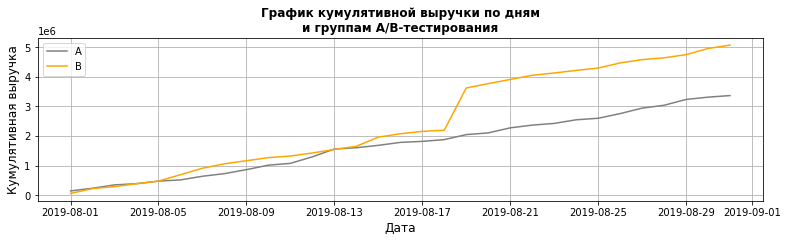

In [19]:
plt.figure(figsize=(13, 3)) # размер графика
# Строим график выручки группы А
plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue'], label='A', color='grey')

# Строим график выручки группы B
plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue'], label='B', color='orange')

plt.xlabel('Дата', fontsize = 12) #Подпись для оси х
plt.ylabel('Кумулятивная выручкa', fontsize = 12) #Подпись для оси y
plt.title('График кумулятивной выручки по дням\nи группам A/B-тестирования', fontsize = 12, fontweight ='bold') #Название
plt.grid() # на график наложим сетку
plt.legend()
plt.show();

#### Вывод по графику кумулятивной выручки
По графику можно сделать следующие выводы:
 - выручка стабильно растет на протяжении всего теста в обеих группах;
 - в начале теста метрика немного колеблется, но показывает близкие значения в обеих группах, группа В незначительно показывает показатели выше;
 - у группы B наблюдается резкий рост 19.08.2019. Этот рост может быть связан или с резким увеличением заказов в этот день, или о появлении заказов с высокой стоимостью в выборке;
 - после единственного выброса в группе B, выручка стабилизируется и продолжает лидировать весь остаток теста, но при этом растет практически одинаково с группой А.
 
Учитывая, что есть подозрение на выброс в группе В, однозначно утверждать, что группа B лучше на данном шаге нельзя, ведь аномально большие заказы влияют на результаты. Необходимо удалить выбросы в дальнейшем и построить график без них.


### График кумулятивного среднего чека по группам A/B-тестирования
#### Строим график кумулятивного среднего чека
Построим для каждой группы график кумулятивного среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов: revenue / orders
 - orders — кумулятивное количество заказов на указанную дату в указанной группе;
 - revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);

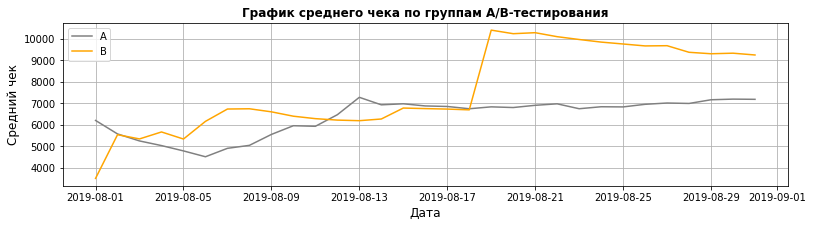

In [20]:
plt.figure(figsize=(13, 3)) # размер графика
# Строим график среднего чека группы А
plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue'] / cum_revenue_a['orders'], label='A', color='grey')
# Строим график среднего чека группы В
plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue'] / cum_revenue_b['orders'], label='B', color='orange')

plt.xlabel('Дата', fontsize = 12) #Подпись для оси х
plt.ylabel('Средний чек', fontsize = 12) #Подпись для оси y
plt.title('График среднего чека по группам A/B-тестирования', fontsize = 12, fontweight ='bold') #Название
plt.grid() # на график наложим сетку
plt.legend()
plt.show();

#### Вывод по графику среднего чека
По графику можно сделать следующие выводы:
 - первую половину времени метрика в обих группах колеблется
 - 14.08.2019 метрика у группы А стабилизируется, у группы В также стабилизируется на уровне группы А, но
 - 19.08.2019 у группы В произошел резкий рост среднего чека и после этого видна тенденция к его снижению. Снижение может быть обусловлено аномально высоким чеком 19.08.2019.

Учитывая, что есть подозрение на выброс в группе В, однозначно утверждать, что средний чек в группе B выше на данном шаге нельзя, ведь аномально высокий чек в какую-то из дат влияет на последующий размер среднего чека. Необходимо удалить выбросы в дальнейшем и построить график без них.


### График относительного изменения кумулятивного среднего чека группы В к группе А
#### Создаем датафрейм с кумулятивной выручкой по группам A/B-тестирования
В датафрейме merged_cum_revenue соберем данные о выручке по группам А и В

In [21]:
merged_cum_revenue = (cum_revenue_a.merge(
   cum_revenue_b,
   left_on='date',
   right_on='date',
   how='left',
   suffixes=['_a', '_b'])
)

merged_cum_revenue.head(3)

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54


#### Строим график относительного различия для среднего чека
Посмотрим на графике отношение средних чеков.


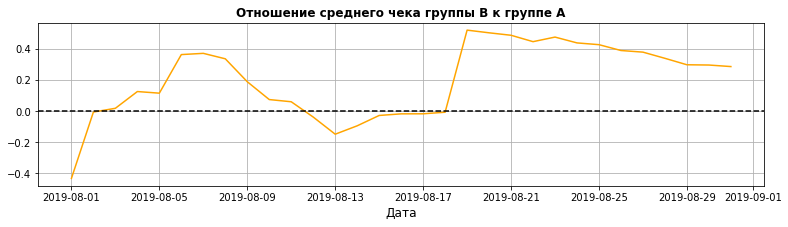

In [22]:
plt.figure(figsize=(13, 3)) # размер графика
# Строим график относительного различия для среднего чека группы В к группе А
plt.plot(
   merged_cum_revenue['date'],
   (merged_cum_revenue['revenue_b'] / merged_cum_revenue['orders_b']) /
   (merged_cum_revenue['revenue_a'] / merged_cum_revenue['orders_a']) - 1,
   label="Отношение величины среднего чека группы В к группе А",
   color='orange'
)

plt.axhline(y=0, color='black', linestyle='--') # добавляем ось X
plt.xlabel('Дата', fontsize = 12) #Подпись для оси х
plt.title('Отношение среднего чека группы В к группе А', fontsize = 12, fontweight ='bold') #Название
plt.grid() # на график наложим сетку
plt.show();

#### Вывод по графику отношения среднего чека группы В к группе А'
По графику можно сделать следующие выводы: 

в первый день теста средний чек группы В был более чем на 40% ниже среднего чека группы А. Но уже не следующий день показатели сравнялись,а в дальнейшем. средний чек группы В рос и 6,7,8 августа колебался и был выше на 35-38%, затем отношение размера чека группы В стало стремиться к группе А. Тут или из-за снижения размера выручки в группе В или из-за роста выручки в группе А. 

12-15 августа средний чек в группе В был ниже до 10% по отношению к группе А. 

17-18 августа показатели почти сравнялись, а 19 августа произошел резкий рост среднего чека по отношению к группе А более чем на 50%. После этого метрика снижается и стремится стабилизироваться, но все равно уровень среднего чека в группе В остался выше на 30% к концу теста.

Учитывая, что есть подозрение на выброс в группе В 19 августа, однозначно утверждать, что средний чек в группе B выше на данном шаге нельзя, ведь аномально высокий чек в какую-то из дат влияет на последующий размер среднего чека. Необходимо удалить выбросы в дальнейшем и построить график без них.


### График кумулятивного среднего количества заказов на посетителя по группам A/B-тестирования
#### Среднее количество заказов на пользователя
В датафрейме cumulative_data добавим столбец conversion в который занесем среднее количество заказов на пользователя.
Для этого orders разделим на visitors.
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [23]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head(3)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390


#### Таблицы по группам
Создадим таблицы отдельно по группам А и В, присвоим им названия cumulative_data_a и cumulative_data_b

In [24]:
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

display(cumulative_data_a.head(2))
cumulative_data_b.head(2)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390


,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,17,17,59758,713,0.023843
3,2019-08-02,B,40,39,221801,1294,0.030912


#### Строим график кумулятивного среднего количества заказов на посетителя по группам

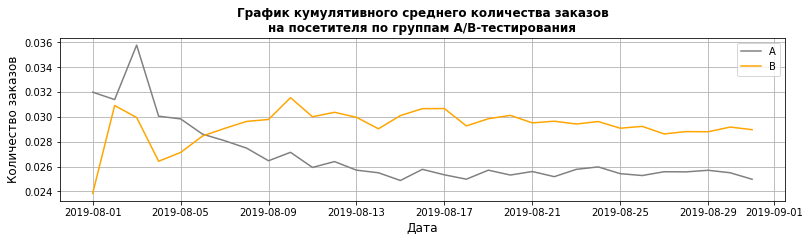

In [25]:
plt.figure(figsize=(13, 3)) # размер графика
# строим график среднего количества заказов группы А
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A', color='grey')
# строим график среднего количества заказов группы В
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B', color='orange')

plt.xlabel('Дата', fontsize = 12) #Подпись для оси х
plt.ylabel('Количество заказов', fontsize = 12) #Подпись для оси y
plt.title('График кумулятивного среднего количества заказов\n\
на посетителя по группам A/B-тестирования', 
          fontsize = 12, 
          fontweight ='bold') #Название
plt.grid() # на график наложим сетку
plt.legend()
plt.show();

#### Вывод по графику кумулятивного среднего количества заказов на посетителя по группам
В начале теста наблюдаем заметные колебания, при этом с начала теста конверсия у группы А была больше чем у группы группы B. 6 августа конверсия группы В выросла, а у группы А началось снижение, причем резкое снижение началось с 4 августа.

Метрики колеблются, но уже к 20 августа они стабилизировались. У группы В показатели конверсии на уровне 2,9-3 % это выше, чем у группы А, где метрика конверсии после стабилизации не превышает 2,6%.

На графике не видно роста заказов 19 августа у группы В. Аномалии на эту дату есть на графиках по выручке, по среднему чеку у группы В. Сильные колебания есть только в первую неделю теста в обеих группах.

В целом, конверсия у группы В стабильно лучше по накопленным показателям чем A.

### График изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
#### Создаем датафрейм с конверсией по группам A/B-тестирования
В датафрейме merged_cum_conversion соберем данные о среднем количестве заказов на посетителя по группам А и В


In [26]:
merged_cum_conversion = (
   cumulative_data_a[['date','conversion']].merge(
       cumulative_data_b[['date','conversion']],
       left_on='date',
       right_on='date',
       how='left', suffixes=['_a', '_b'])
)
merged_cum_conversion.head(2)

,date,conversion_a,conversion_b
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912


#### Строим график относительного различия среднего количества заказов на посетителя группы B к группе A

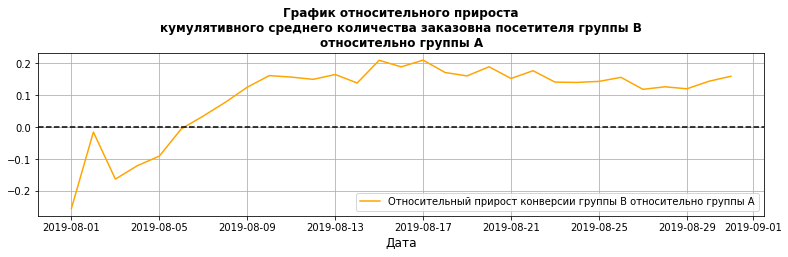

In [27]:
plt.figure(figsize=(13, 3)) # размер графика
# Строим график относительного различия для кол-ва заказов на посетителя группы В к группе А
plt.plot(
   merged_cum_conversion['date'], merged_cum_conversion['conversion_b'] /
   merged_cum_conversion['conversion_a']-1,
   label="Относительный прирост конверсии группы B относительно группы A",
   color='orange'
)

plt.axhline(y=0, color='black', linestyle='--')  # добавляем ось X
plt.xlabel('Дата', fontsize = 12) #Подпись для оси х
plt.title('График относительного прироста\nкумулятивного среднего количества заказов\
на посетителя группы B\nотносительно группы A', #Название
          fontsize = 12, 
          fontweight ='bold') 
plt.grid() # на график наложим сетку
plt.legend()
plt.show();


#### Вывод по графику относительного различия среднего количества заказов на посетителя группы B к группе A
C самого начала теста, количество заказов у группы В меньше группы А, метрика колеблется. С 6 августа показатели выросли и количество заказов после 6 августа стабильно росло и достигло пика до своего пика 15 и 17 августа, превысив примерно на 20% количество заказов группы А. После этого метрика снижается и стремится к стабилизации.

В целом отношение среднего количества заказов на посетителя больше у группы B, метрика стремится к стабилизации. Но колебания незначительные есть и на конец теста в диапазоне 12-17%.

Можно предположить, что равновесие еще не установилось, но на первый взгляд B выглядит интереснее в плане конверсии - прирост есть.

Проверим данные на аномалии. У нас есть предположение, что 19 августа были заказы с аномально высокой стоимостью. Такие заказы редкость и они влияют на все метрики, искажая реальную картину. Начнем с оценки стоимости заказов с помощью точечного графика, затем посчитаем 95-й и 99-й персентиль стоимости заказов, посчитаем статистическую значимость.

### Точечный график количества заказов по пользователям
Проанализируем конверсию - отношение числа заказов к количеству посетителей сайта за время теста.. Пользователи, совершившие  много заказов, влияют на численность формулы конверсии. Метрика искажается. Скорее всего такое поведение отличается от нормального, обычный пользователь интернет-магазина с регулярным спросом (как  наш магазин) совершает не более двух заказов за короткий срок.

#### Датафрейм с количество заказов по пользователям
Посчитаем количество заказов по пользователям и посмотрим на результат. Сгруппируем датафрейм orders по пользователям ('visitor_id) и посчитаем заказы(transaction_id).

In [28]:
ord_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ord_by_users.columns = ['visitor_id', 'orders'] # переименуем столбцы

ord_by_users.sort_values(by='orders', ascending=False).head(10) #выведем топ-10 количества покупок на пользователя

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Есть некоторые пользователи, которые оформили по 3 заказа, их не много. Посмотрим как это выглядит на точечной диаграмме, чтобы оценить как такие пользователи выделяются на фоне других.

#### Cтроим точечную диаграмму числа заказов одного пользователя

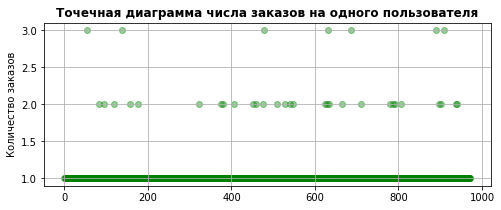

In [29]:
x_values = pd.Series(range(0, len(ord_by_users))) # считаем количество заказов общее
# строим точечную диаграмму числа заказов одного пользователя
plt.figure(figsize=(8, 3))
plt.scatter(x_values, 
            ord_by_users['orders'], 
            cmap="jet", 
            alpha=0.4, 
            color='green')

plt.title('Точечная диаграмма числа заказов на одного пользователя', 
          fontsize = 12, 
          fontweight ='bold')
plt.grid() # на график наложим сетку
plt.ylabel('Количество заказов')

plt.show();

#### Вывод по точечной диаграмме числа заказов одного пользователя

Судя по диаграмме, можно сделать вывод, что самое большое число пользователей сделало по одному заказу. 

По два заказа сделало мало пользователей. Их точная доля не ясна — непонятно, считать их аномалиями или нет. 

По три заказа - единичные случаи.

Посчитаем выборочные перцентили количества заказов на одного пользователя чтобы отсечь выбросы, так как по графику неясно, считать заказы с тремя и двумя заказами аномалией или нет. 

### Считаем 95-й и 99-й персентили количества заказов по пользователям
Принято отсекать от 1% до 5% наблюдений с крайними значениями. Чтобы их найти применим метод  percentile() библиотеки Numpy: 

In [30]:
print(np.percentile(ord_by_users['orders'], [95, 99])) 

[1. 2.]


#### Граница для определения аномалии количества заказов
Не более 5% пользователей оформляли больше чем 1 заказ. И не более 1% пользователей заказывали более двух раз.

Можно не сомневаясь установить 1 заказ на одного пользователя как нижнюю границу нормального числа заказов. Таким образом нужно отсеять пользователей, совершивших более 1 заказа за время проведения теста.

### Точечный график стоимости заказов
У нас есть предположения, что среди заказов есть заказы с аномально высокой стоимостью. Такие покупки редкость, случайность. Их нужно удалять из выборки, чтобы не искажать метрики. Для начала сформируем датасет с заказами и их стоимостью.

#### Посмотрим количество заказов по стоимости
Посмотрим количество заказов по стоимости из датасета orders

In [31]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A
949       1347999392   887908475 2019-08-21    60450     A
940       2420050534  4003628586 2019-08-08    58550     B
131       3163614039  2254586615 2019-08-22    53904     A


Вывели топ-10 самых дорогих заказов. Один заказа почти на миллион триста тысяч, а замыкает десятку лидеров заказ на 54 тысячи . Даже среди топ-10 разброс сильный и есть аномалия. Посчитаем количество заказов и запишем информцию в переменной x_values. а затем построим точечную диаграмму.

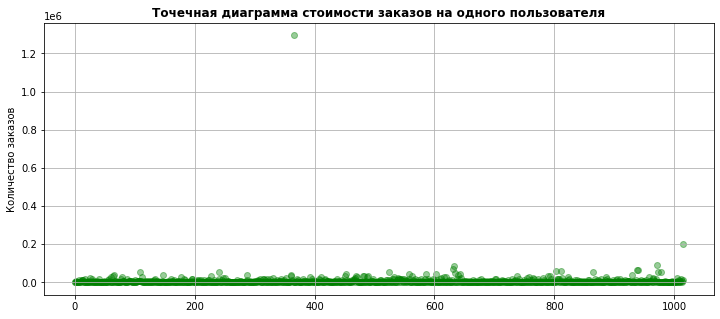

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(12, 5))
plt.scatter(x_values, 
            orders['revenue'], 
            cmap="jet", 
            alpha=0.4, 
            color='green')
plt.grid() # на график наложим сетку
plt.title('Точечная диаграмма стоимости заказов на одного пользователя', 
          fontsize = 12, 
          fontweight ='bold')
plt.ylabel('Количество заказов')
plt.show();

#### Вывод по точечной диаграмме стоимости заказов на одного пользователя

Судя по диаграмме, можно сделать вывод, что найденный заказ на миллион триста тысяч - точно выбивается из всех заказов. Также есть заказ на 200тысяч. Остальные заказы не превышают 50тысяч. Чтобы точно отсеять аномалии, почитаем выборочные перцентили стоимости заказов на одного пользователя.

### Считаем 95-й и 99-й выборочные перцентили cтоимости заказов на одного пользователя

In [33]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


#### Граница для определения аномалии стоимости заказов
Не более 5% заказов дороже 26 785 и не более 1% дороже 53904. Как мы и предполагали, наши дорогие заказы на миллион триста тысяч и на  двести тысяч  составляют менее 1% от всех заказов. Остается решить какой порог стоимости заказов установить. По количеству заказов мы отсеяли 5% аномального количества заказов. Применим и тут такой же размер аномалии в 5% и установим верхнюю границу заказа в  26785 рублей.

## Анализ А/В теста: анализ результатов

Мы уже оценили результаты А/В теста визуально и сделали предположение,что в данных есть выбросы. Нашли эти выбросы, определили для них границу, а именно:
 - не более 1 заказа на пользователя
 - не более 26 785 стоимость одного заказа.

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами.
Сделаем это как по сырым данным - без удаления аномальных пользователей, так и по очищенным данным от выбросов. 

Для всех данных(сырых и очищенных) сформулируем гипотезы о наличии различий между группами.  

### Анализ результатов по сырым данным
Посчитаем статистическую значимость различий в среднем числе заказов на пользователя на пользователя и среднем чеке между группами по данным до очистки(сырым).

#### Проверка данных на нормальность. Критерий Шапиро-Уилка

C помощью критерия Шапиро-Уилка проверим гипотезу о нормальном распределении. Выбор в пользу этого критерия в том, что он чаще обнаруживает различия между распределениями, если они и правда есть. Библиотека scipy.stats имеет встроенный расчет этого критерия - метод st.shapiro(x). 

 - Сформулируем гипотезы для проверки групп А:

    - H0:Конверсии группы A распределены нормально 
    - H1:Конверсии группы A не распределены нормально
 
α=5% критический уровень статистической значимости.

 - Сформулируем гипотезы для проверки групп В:
    - H0:Конверсии группы A распределены нормально 
    - H1:Конверсии группы A не распределены нормально
 
α=5% критический уровень статистической значимости.

На основе датафрейма visitors подготовим данные для двух групп А и В
 - visitors_a_daily
 - visitors_b_daily
 
 - visitors_a_cum
 - visitors_b_cum

На основе датафрейма orders подготовим данные для двух групп А и В

 - orders_a_daily
 - orders_b_daily
 
 - orders_a_cum
 - orders_b_cum

Соединим все полученные данные с помощью merge в таблицу raw_data

Используем датафрейм orders как основу для создания переменных ord_by_users_a и ord_by_users_b, в которые запишем столбцы с пользователями и количеством заказов, которые они совершали.

Затем объявим переменные 
 - sample_a и  
 - sample_b,
 в которых пользователям (visitor_id) из разных групп будет соответствовать количество заказов(transaction_id). Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

Переменная sample_a и sample_b состоит из двух частей: 
- Список с количеством заказов для каждого из пользователей,
- Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах.

In [34]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'a_user_per_date']

visitors_a_cum = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'a_user_per_date': 'sum'}
    ),
    axis=1,
)
visitors_a_cum.columns = ['date', 'a_user_cum']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'b_user_per_date']

visitors_b_cum = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'b_user_per_date': 'sum'}
    ),
    axis=1,
)
visitors_b_cum.columns = ['date', 'b_user_cum']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'a_orders_per_date', 'a_revenue_per_date']

orders_a_cum = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'a_orders_per_date': 'sum', 'a_revenue_per_date': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cum.columns = [
    'date',
    'a_orders_cum',
    'a_cum_revenue',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'b_orders_per_date', 'b_revenue_per_date']

orders_b_cum = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'b_orders_per_date': 'sum', 'b_revenue_per_date': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cum.columns = [
    'date',
    'b_orders_cum',
    'b_cum_revenue',
]

data = (
   orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cum, left_on='date', right_on='date', how='left')
    .merge(orders_b_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cum, left_on='date', right_on='date', how='left')
)

# для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов
orders_a_users = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_a_users.columns = ['user_id', 'orders']

orders_b_users  = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_b_users.columns = ['user_id', 'orders'] 

# пользователям с заказами будет соответствовать число заказов пользователя, а пользователям без заказов — нули
sample_a = (
    pd.concat(
    [orders_a_users['orders'],pd.Series(0, index=np.arange(data['a_user_per_date'].sum()
    - len(orders_a_users['orders'])), name='orders')],axis=0)
           )

sample_b = (
    pd.concat(
        [orders_b_users['orders'],pd.Series(0, index=np.arange(data['b_user_per_date'].sum() 
        - len(orders_b_users['orders'])), name='orders')],axis=0)
)

# зададим уровень значимости 5%
alpha = 0.05
p = stats.shapiro(sample_a)
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % p)
if p[1] > alpha:
    print('Принять гипотезу о нормальности распределении, группа А')
else:
    print('Отклонить гипотезу о нормальности распределении, группа А')
    
p = stats.shapiro(sample_b)
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % p)
if p[1] > alpha:
    print('Принять гипотезу о нормальности распределении, группа В')
else:
    print('Отклонить гипотезу о нормальности распределении, группа В')

Shapiro-Wilk normality test, W-statistic: 0.132646, p-value: 0.000000
Отклонить гипотезу о нормальности распределении, группа А
Shapiro-Wilk normality test, W-statistic: 0.150587, p-value: 0.000000
Отклонить гипотезу о нормальности распределении, группа В


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



#### Итоги проверки данных на нормальность. Критерий Шапиро-Уилка.

Поскольку p-значение у группы А и у группы В меньше 0,05, мы отвергаем нулевую гипотезу. У нас нет достаточно доказательств, чтобы сказать, что данные выборки имеют нормальное распределение.

Раз в обоих группах данные не распределены нормально, поэтому используем U-критерий Манна — Уитни.


#### Cтатистическая значимость различия в среднем количестве заказов между группами. Сырые данные
Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей. Применим U-критерий Манна — Уитни для сырых данных.

По итогу выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

Напомним, что в sample_a сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. 

Значит, число элементов sample_a — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей — найдём среднее в выборке sample_a методом mean(). Аналогично найдём среднее группы B: Sample_b.mean().

Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.

Сформулируем гипотезы для сырых данных так:
 - H0:Конверсии групп A и B равны, статистически значимых отличий нет 
 - H1:Конверсии групп A и B различны, статистически значимые отличия есть
 
α=5% критический уровень статистической значимости. 

In [35]:
alpha = 0.05
result_1 = stats.mannwhitneyu(sample_a, sample_b)[1]
ratio_1 = sample_b.mean() / sample_a.mean() - 1
if result_1 < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')
print('р-значение:', "{0:.3f}".format(result_1))

print('Относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(ratio_1 ))

Отвергаем нулевую гипотезу: разница статистически значима.
р-значение: 0.011
Относительный прирост среднего числа заказов группы B: 0.160


#### Итоги теста Уилкоксона-Манна-Уитни на сырых данных, конверсия заказов
По данным, не очищенным от выбросов тест показал статистически значимую разницу в конверсии заказов, иными словами, конверсии различаются значимо. 

По этим данным можно сказать, что группа В показала большую конверсию, чем группа А. Разница в приросте заказов у группы В перед группой А составила 16%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.
Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

Сформулируем гипотезы для сырых данных так:
 - H0:Средние чеки групп A и B равны, статистически значимых отличий нет  
 - H1:Средние чеки групп A и B различны, статистически значимые отличия есть
 
α=5% критический уровень статистической значимости. 


Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.  А ещё найдём относительные различия в среднем чеке между группами:

In [36]:
alpha = 0.05
result_rev_1 = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
ratio_rev_1 = orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()-1
if result_rev_1 < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')
print('р-значение:', "{0:.3f}".format(result_rev_1 ))
print('Относительный прирост среднего чека заказов группы \
B:', "{0:.3f}".format(ratio_rev_1))

Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
р-значение: 0.829
Относительный прирост среднего чека заказов группы B: 0.287


#### Итоги теста Уилкоксона-Манна-Уитни на сырых данных о среднем чеке
Учитывая, что p-value 0,829 больше установленного уровня значимости, то статистически значимой разницы между размером среднего чека в группе А и группе В нет, иными словами нет оснований отвергнуть нулевую гипотезу о равенстве среднего чека у групп.

При этом у нас есть показатель 28,7% относительного различия в среднем чеке между группами (отношение  группы В к группе А). 

Надо смотреть очищенные данные от выбросов.

### Анализ результатов по очищенным от выбросов данным
Посчитаем статистическую значимость различий в среднем числе заказов на пользователя на пользователя и среднем чеке между группами по данным после очистки.

### Очищаем данные от выбросов
Уберем пользователей с  числом заказов больше 1 и пользователей с заказами свыше  26785 рублей.
Запишем количество пользователей с выбросами в переменную:
 - anomaly_orders  - по заказам 
 - anomaly_expensive - по стоимости заказа

Объединим полученные данные в датафрейм: 
 - abnormal_users

Выведем на экран количество таких пользователей. Затем  подготовим выборки количества заказов по пользователям по группам теста и запишем их в переменные: 
 - sample_a_filtered - для группы А
 - sample_b_filtered - для группы В


In [37]:
# Уберем пользователей с  числом заказов больше 1 и пользователей с заказами свыше  26785 рублей.
anomaly_orders = pd.concat(
    [
        orders_a_users[orders_a_users['orders'] > 1]['user_id'],
        orders_b_users[orders_b_users['orders'] > 1]['user_id'],
    ],
    axis=0,
)
anomaly_expensive = orders[orders['revenue'] > 26785]['visitor_id']
abnormal_users = (
    pd.concat([anomaly_orders, anomaly_expensive], axis=0)
    .drop_duplicates()
    .sort_values()
)
#Выведем на экран количество таких пользователей
display(abnormal_users.head(2))
print('Число пользователей подлежащих удалению из выборки:', abnormal_users .shape[0]) 

568     113298937
1099    148427295
dtype: int64

Число пользователей подлежащих удалению из выборки: 86


In [38]:
# подготовим выборки количества заказов по пользователям по группам теста
sample_a_filtered = pd.concat(
    [
        orders_a_users[
            np.logical_not(orders_a_users['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['a_user_per_date'].sum() - len(orders_a_users['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_b_users[
            np.logical_not(orders_b_users['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['b_user_per_date'].sum() - len(orders_b_users['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#### Cтатистическая значимость различия в среднем количестве заказов между группами. Очищенные данные
Узнаем как удаленные пользователи влияли на метрики. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Применим статистический критерий Манна-Уитни к полученным выборкам.

Сравним результаты по сырым данным и по очищенным данным.

In [39]:
alpha = 0.05
result_2 = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]
ratio_2 = sample_b_filtered.mean() / sample_a_filtered.mean() - 1

if result_2 < alpha:
    print('Очищенные данные. Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Очищенные данные. Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')
#добавляем вывод по сырым данным для сравнения результата
if result_1 < alpha:   
    print('    Сырые данные. Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('    Сырые данные. Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')   
#в вывод добавляем вывод по сырым данным для сравнения результата     
print('Очищенные данные: р-значение:', "{0:.3f}".format(result_2), \
      '\n    Cырые данные: р-значение:', "{0:.3f}".format(result_1))

print('Очищенные данные: относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(ratio_2),\
     '\n    Сырые данные: относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(ratio_1))

Очищенные данные. Отвергаем нулевую гипотезу: разница статистически значима.
    Сырые данные. Отвергаем нулевую гипотезу: разница статистически значима.
Очищенные данные: р-значение: 0.016 
    Cырые данные: р-значение: 0.011
Очищенные данные: относительный прирост среднего числа заказов группы B: 0.174 
    Сырые данные: относительный прирост среднего числа заказов группы B: 0.160


#### Итоги теста Уилкоксона-Манна-Уитни на очищенных данных, конверсия заказов
Выводы по тестам по сырым данныи и очищенным данным одинаковы: разница в количестве заказов статистически значима. 

Можно увидеть, что после очистки, p-value незначительно увеличился с 0.011 до 0.016, а конверсия также подросла в пользу группы В с 16% до 17,4 %.

Посмотрим, как повлияли выбросы на средний чек.

#### Cтатистическая значимость различия в среднем чеке заказа между группами. Очищенные данные

Сформулируем гипотезы для очищенных данных так:
 - H0:Средние чеки групп A и B равны, статистически значимых отличий нет  
 - H1:Средние чеки групп A и B различны, статистически значимые отличия есть
 
α=5% критический уровень статистической значимости. 


Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.  А ещё найдём относительные различия в среднем чеке между группами:

In [40]:
alpha = 0.05
result_rev_2 = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',\
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'], 
                   orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'],)[1]

ratio_rev_2 = orders[np.logical_and(orders['group'] == 'B',\
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean()\
        / orders[np.logical_and(orders['group'] == 'A',\
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean() - 1

if result_rev_2 < alpha:
    print('Очищенные Данные.Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Очищенные Данные. Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')
#добавляем вывод по сырым данным для сравнения результата
if result_rev_1 < alpha:
    print('    Сырые Данные.Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('    Сырые Данные. Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')
print('Очищенные Данные: р-значение:', "{0:.3f}".format(result_rev_2), \
      '\n    Cырые данные: р-значение:', "{0:.3f}".format(result_rev_1))
#в вывод добавляем вывод по сырым данным для сравнения результата
print('Очищенные данные: относительный прирост среднего чека заказов группы B:', "{0:.3f}".format(ratio_rev_2),\
     '\n    Сырые данные: относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(ratio_rev_1))

Очищенные Данные. Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
    Сырые Данные. Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
Очищенные Данные: р-значение: 0.727 
    Cырые данные: р-значение: 0.829
Очищенные данные: относительный прирост среднего чека заказов группы B: -0.034 
    Сырые данные: относительный прирост среднего числа заказов группы B: 0.287


####  Итоги теста Уилкоксона-Манна-Уитни на очищенных данных о среднем чеке
Учитывая, что p-value 0,727 больше установленного уровня значимости, то статистически значимой разницы между размером среднего чека в группе А и группе В нет, иными словами нет оснований отвергнуть нулевую гипотезу о равенстве среднего чека у групп.

При этом на сырых данных этот показатель был 0,829, это выше, чем на очищенных, но на общий вывод по результатам теста это не повлияло. 

Показатель прироста среднего чека у группы В относительно группы А составил минус 3,4%, а на неочищенных данных было плюс 28,7%. Видим, что выбросы исказили метрику.

Можно сделать вывод, что без аномально дорогих заказов, средний чек в группе В ниже на 3,4%, чем в группе А.

Это еще раз убеждает нас, что статистически значимых различий по этой метрике между группами нет, а наблюдаемая на неочищенных данных разница, как мы и предполагали, была связана с аномалиями.

## Вывод

По результатам расчетов можно сделать следующие выводы.
- статистически значимые различия по конверсии между группами есть. Причем как по сырым так и по очищенным данным. Группа В имеет преимущество перед группой А в 16-17%;

- статистически значимых различий по среднему чеку между группами нет. Причем как по сырым так и по очищенным данным;

- график различия конверсий между группами показывает, что результаты группы B лучше группы A в конце исследования приблизительно на 13-17%. Наблюдается тенденция к еще небольшому улучшению;
- график различий кумулятивного среднего чека показывает о преимуществе группы B на дату выброса, после чего метрика начинает снижаться и стремится к более естественному положению.

Исходя из обнаруженных фактов тест следует остановить и признать его успешным в части улучшения конверсии в целевой группе B.

В части среднего чека нельзя утверждать, что какая - либо из групп имеет преимущество над другой. 

Нет оснований полагать, что при продолжении теста между группами в конверсиях либо среднем чеке метрики значительно изменятся, на это указывает то, что колебания в графиках носят затухающий характер.